Для выполнения задания требуется разработать модель, которая будет способна различать заголовки реальных и выдуманных новостей. <br/>
Для обучения модели будут использоваться данные из файла `train.tsv`. В файле находится таблица, состоящая из двух колонок. В колонке title записаны заголовки новостей. В колонке is_fake содержатся метки: 0 – новость реальная; 1 – новость выдуманная. <br/>
Для демонстрации работы модели используются данные тестового набора из файла `test.tsv`. В нем также есть колонка title, данные которой являются входными для модели. <br/>
Необходимо скопировать файл `test.tsv`, переименовать его в `predictions.tsv` и заполнить колонку is_fake значениями предсказания модели, аналогично `train.tsv`. <br/>
Изначально колонка заполнена значением 0.

Импортируем модули для первоначальной оценки датасета.

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [47]:
df = pd.read_csv("../nlp_test_task_2022/dataset/train.tsv", sep='\t')

In [48]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5758 entries, 0 to 5757
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    5758 non-null   object
 1   is_fake  5758 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 90.1+ KB


In [49]:
df.isnull().sum()

title      0
is_fake    0
dtype: int64

Блоком выше проверили имеются ли значения NaN в исследуемом наборе данных и у нас их не оказалось.

In [56]:
df.iloc[75:86]

,title,is_fake
75,Минэнерго ФРГ выпустило обучающие ролики по по...,1
76,Российскую орбитальную станцию сформируют из п...,0
77,Ставший мемом дед Гарольд привязал к стулу дом...,0
78,Умерла поэтесса Андре Шедид,0
79,70-летняя аргентинка забеременела после привив...,1
80,Доллар рухнул после отказа ФНБ от американской...,1
81,В Польше готовятся издать поэму Папы Римского,0
82,"В Подмосковье третьи сутки ищут полицейского, ...",1
83,Олимпийские винтовки Бьорндалена по ошибке отп...,0
84,Четырехкратная олимпийская чемпионка ушла из с...,0


* title (object): заголовки статей/новостей
* is_fake (int64): 0 - реальный заголовок, 1 - фейк

Оценим соотношение реальных и фейковых заголовков в наборе данных.

In [6]:
#количество значений разными метками
df['is_fake'].value_counts()

1    2879
0    2879
Name: is_fake, dtype: int64

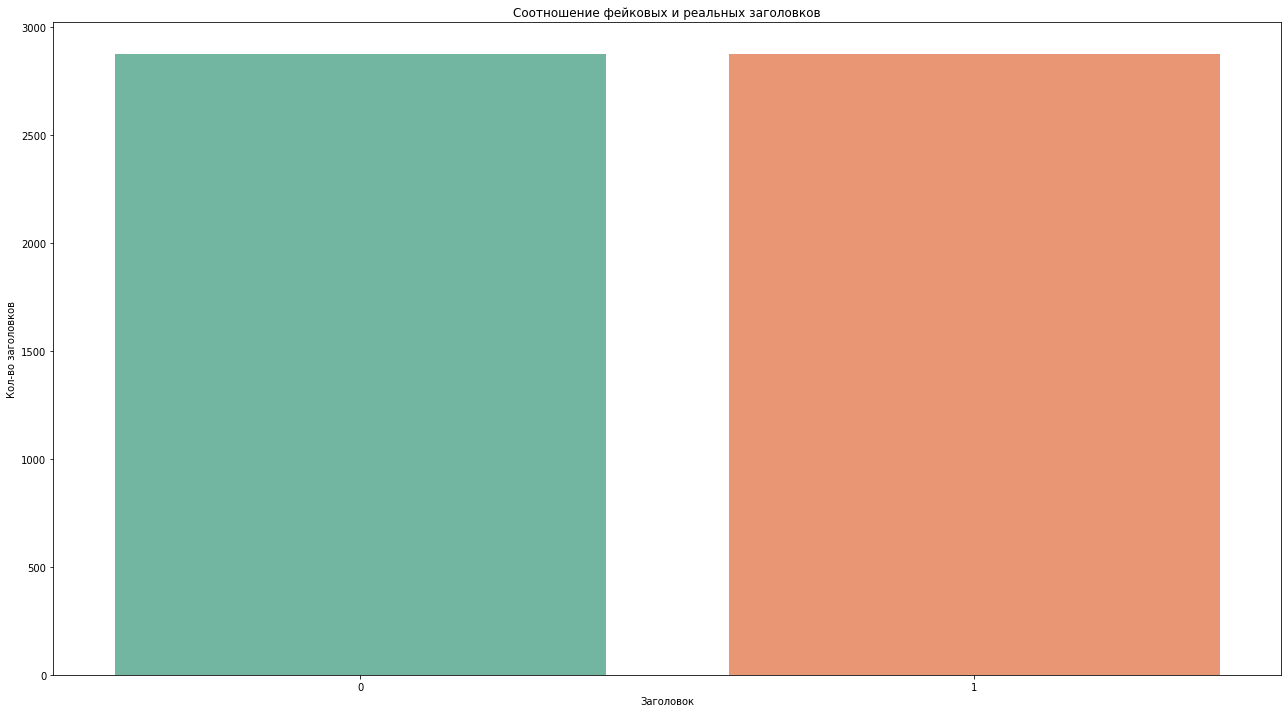

In [7]:
fig, ax = plt.subplots(figsize=(22,12))
sns.countplot(x=df["is_fake"], palette="Set2")
ax.set(title="Соотношение фейковых и реальных заголовков")
plt.ylabel("Кол-во заголовков")
plt.xlabel("Заголовок")
plt.show()

Заметим из графика, что соотношение реальных и фейковых заголовков составляет 50% на 50%.

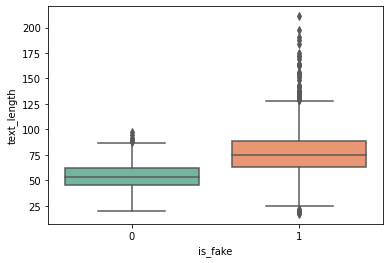

In [8]:
df['text_length'] = df['title'].apply(lambda x: len(x))
sns.boxplot(y='text_length', x='is_fake', data=df, palette="Set2")
plt.show()

Из данного графика можно заметить, что медиана и количество выбросов у фейковых новостей выше, чем у реальных. <br/>
(Можно использовать как доп.признак, но я не понял как его использовать).

Перед тем как создать "мешок слов" удалим стоп-слова с помощью набора stopwords для русского языка и проведем лемматизацию.

- Off top: что такое "мешок слов"?

"Мешок слов" - наиболее распространенный метод преобразование текста в признаки. Данные методы выводят признак для каждого уникального слова в текстовых данных, но при этом каждый признак содержит количество вхождений в наблюдениях. <br/> Например, в предложении "Бразилия - моя любовь. Бразилия!" имеет значение `2` в признаке "Бразилия", потому что слово Бразилия появляется два раза.

In [9]:
from nltk.corpus import stopwords
#from nltk.corpus import 
stopWords = stopwords.words("russian")
print(stopWords)

['и', 'в', 'во', 'не', 'что', 'он', 'на', 'я', 'с', 'со', 'как', 'а', 'то', 'все', 'она', 'так', 'его', 'но', 'да', 'ты', 'к', 'у', 'же', 'вы', 'за', 'бы', 'по', 'только', 'ее', 'мне', 'было', 'вот', 'от', 'меня', 'еще', 'нет', 'о', 'из', 'ему', 'теперь', 'когда', 'даже', 'ну', 'вдруг', 'ли', 'если', 'уже', 'или', 'ни', 'быть', 'был', 'него', 'до', 'вас', 'нибудь', 'опять', 'уж', 'вам', 'ведь', 'там', 'потом', 'себя', 'ничего', 'ей', 'может', 'они', 'тут', 'где', 'есть', 'надо', 'ней', 'для', 'мы', 'тебя', 'их', 'чем', 'была', 'сам', 'чтоб', 'без', 'будто', 'чего', 'раз', 'тоже', 'себе', 'под', 'будет', 'ж', 'тогда', 'кто', 'этот', 'того', 'потому', 'этого', 'какой', 'совсем', 'ним', 'здесь', 'этом', 'один', 'почти', 'мой', 'тем', 'чтобы', 'нее', 'сейчас', 'были', 'куда', 'зачем', 'всех', 'никогда', 'можно', 'при', 'наконец', 'два', 'об', 'другой', 'хоть', 'после', 'над', 'больше', 'тот', 'через', 'эти', 'нас', 'про', 'всего', 'них', 'какая', 'много', 'разве', 'три', 'эту', 'моя', 'впр

In [10]:
import pymorphy2
import re #регулярные выражения
from string import punctuation #сборник символов пунктуации
from nltk.tokenize import word_tokenize #для токенизации по словам

С помощью `pymorphy2` приведем слова к нормальной (начальной) форме: например <br/>
* “люди -> человек”, 
* “гулял -> гулять”.

Начальную форму слова можно получить через атрибуты `Parse.normal_form` и `Parse.normalized`. Чтоб получить объект `Parse`, нужно сперва разобрать слово и выбрать правильный вариант разбора из предложенных.

In [11]:
morph = pymorphy2.MorphAnalyzer()

Проведем очистку текстовых данных от символов пунктуации, также приведем весь текст к нижнему регистру и выберем начальную форму каждого слова в заголовке.

In [12]:
def lemmatize(content):
    review = re.sub('(?i)[^А-ЯЁA-Z]',' ',content)
    review = review.lower()
    review = review.split()
    review = [morph.parse(word)[0].normal_form for word in review if not word in stopwords.words('russian')]
    review = ' '.join(review)
    return review

Применяем функцию для очистки текста к заголовкам

In [13]:
df['title_normalize'] = df['title'].apply(lemmatize)

Посмотрим что получилось:

In [15]:
for i in df['title_normalize']:
    print(i)

москвич владимир клутина прийти счёт вмешательство американский выборы
агент кокорин назвать езда встречка житейский история
госдума рассмотреть возможность введение секретный стать уголовный кодекс
фас заблокировать поставка скоростной трамвай москва
против навальный завести дело недоносительство волков
российский студент запретить учиться рубеж
путин писать книга история украина
россиянин обхитрить рост цена
звезда воронин раскрыть подробность свой состояние
microsoft объявить дата выход очко дополнить реальность hololens
марат хуснуллин призвать прописать закон понятие многонациональный дом
проведение профилактический работа сентябрь россия отключить интернет
россия ввести обязательный техосмотр садовый инвентарь
топилина провозгласить окончание зарплатный кризис россия
режиссёр алексей герман наградить орден
олафа шольц дед рассказывать какой вкусный украина кура молоко яйцо
беглов петербург основать наш эра полтора тысяча год старший москва
случай дефицит препарат эпиваккорона хра

цена нефть wti снизиться публикация данные запас сша
линда хэмилтон сыграть мать живой компьютер
съёмка хоббит отложить язва питер джексон
швейцарский выставка участие ларри кларк подвергнуть цензура
россия признать независимость косово обмен признание крым
уголовный ответственность вместо депутат быть нести голосовать избиратель
год население хабаровский край вырасти полмиллиона глава регион мочь представить госнаграда
oshkosh получить заказ тысяча бронетранспортёр
выйти трейлер персональный покупатель кристен стюарт
клим шипенко потерять видеозапись сделать борт мкс
депутат кпрф госпитализировать укус гремучий змея который пытаться раздавить ботинок
видео kuzno productions итальянец пробовать тюремный баланда возглавить тренд youtube
астронавт выйти космос ремонтировать оборудование мкс
челси упустить шанс выйти лидер чемпионат англия
чубайс отменить продажа акция роснано
отместка блокировка немецкоязычный youtube канал rt российский турист обесточить турецкий отель постоялец германи

флаг фбк бросить подножие мавзолей время парад победа
реконструкция пушкинский музей выделить миллиард рубль
сми запретить называть навальный фамилия
билли эллиот стать британский фильм год
компания mail ru group запретить власть сша пользоваться мессенджер icq
отмена qr код москва отметить ресторанный фестиваль
чиновник признать законный производство ваттный лампа
промпроизводство россия вырасти процент
лукашенко саммит вообще состояться
самолёт вадим красносельский экстренно приземлиться румыния
касьянов хотеться ехать давос
непривитый школьник допустить сдача огэ егэ
группа тат отказаться работать иван шаповалов
россия перевести десятилетний финансовый план
qr код заменить фотография российский паспорт новый образец
генетика подтвердить уникальность носитель щёлкать язык
рпц росгвардия подписать меморандум создание военизированный корпус стража возродить православие
радиация один компьютерный монитор уничтожить тысяча таракан месяц
россиянин использовать туалет выгребной яма обязать

Разделим тренировочный набор данных на обучающую и тестовую выборки.

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
x_train,x_test,y_train,y_test=train_test_split(df['title_normalize'], 
                                               df['is_fake'], 
                                               test_size=0.2, 
                                               random_state=7)

In [18]:
print('Тренировочный набор:', x_train.shape)
print('Тестовой набор:', x_test.shape)

Тренировочный набор: (4606,)
Тестовой набор: (1152,)


Импортируем библиотеки необходимые для обучения модели:

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier,LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

Для "мешка слов" будут отбираться слова, взвешенные по их важности для наблюдения. То есть необходимо сравнить частоту слова в заголовке с частотой слова во всех других заголовках, используя статистическую меру словарной частоты - обратной документной частоты (`tf-idf`). Библиотека `Scikit-Learn` позволяет легко это делать с помощью класса `TfidfVectorizer`:

In [20]:
tfidf_vectorizer=TfidfVectorizer(stop_words=stopWords, max_df=0.7)

Обучение и преобразование переменных `x_train` и `x_test`

In [21]:
tfidf_train=tfidf_vectorizer.fit_transform(x_train) 
tfidf_test=tfidf_vectorizer.transform(x_test)

Теперь перейдем к самому интересному и интригующему пункту - выбор классификатора и его оценка на тестовой выборке. <br/>

Мною были рассмотрены, на мой взгляд, самые популярные классификаторы для NLP задач, а именно:
* PassiveAggressiveClassifier
* MultinomialNB (Naive Bayes)
* Logistic Regression
* Linear SVC 

Ниже будет приведен датафрейм, в котором указаны результаты каждого классификатора

#### Первый на очереди PassiveAggressiveClassifier

In [22]:
pac=PassiveAggressiveClassifier(max_iter=50)
pac.fit(tfidf_train, y_train)

y_pred=pac.predict(tfidf_test)
score_pac=accuracy_score(y_test, y_pred)
print(f'Точность PassiveAggressiveClassifier: {round(score_pac*100,2)}%')

Точность PassiveAggressiveClassifier: 82.73%


Ниже показан отчет о классификации и матрица ошибок. <br/>

Что можно заметить по матрице ошибок? <br/>
А то, что 99 (цифра приведена в моем (последнем) запуске блокнота) заголовков имеют ошибку 1-го рода, то есть модель предсказала положительный результат, а на самом деле он отрицательный.
И 93 заголовка, которые имеют ошибку 2-го рода – модель предсказала отрицательный результат, но на самом деле он положительный

In [23]:
confusion_matrix(y_test,y_pred)

array([[472, 102],
       [ 97, 481]])

Функция `classification_report` возвращает `recall`, `precision` и `F`-меру для каждого из классов, а также количество экземпляров каждого класса.

In [24]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.83      0.83       569
           1       0.83      0.83      0.83       583

    accuracy                           0.83      1152
   macro avg       0.83      0.83      0.83      1152
weighted avg       0.83      0.83      0.83      1152



Дополнительно импортируем библиотеки для отрисовки матрицы ошибок.

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

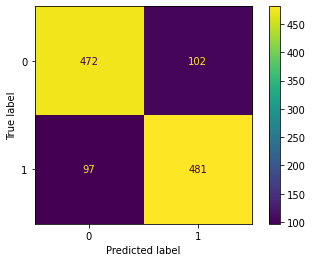

In [26]:
cm = confusion_matrix(y_test, y_pred, labels=pac.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=pac.classes_)
disp.plot()
plt.show()

#### Второй классификатор - MultinomialNB

In [27]:
NB= MultinomialNB()
NB.fit(tfidf_train, y_train)

y_pred=NB.predict(tfidf_test)
score_NB=accuracy_score(y_test, y_pred)
print(f'Точность MultinomialNB: {round(score_NB*100,2)}%')

Точность MultinomialNB: 85.59%


In [28]:
confusion_matrix(y_test,y_pred)

array([[468, 106],
       [ 60, 518]])

In [29]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.82      0.89      0.85       528
           1       0.90      0.83      0.86       624

    accuracy                           0.86      1152
   macro avg       0.86      0.86      0.86      1152
weighted avg       0.86      0.86      0.86      1152



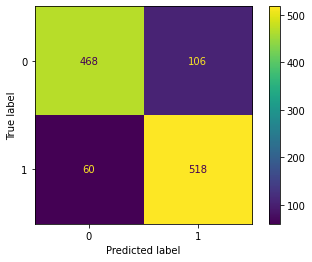

In [30]:
cm = confusion_matrix(y_test, y_pred, labels=NB.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=NB.classes_)
disp.plot()
plt.show()

#### Следом посмотрим на Logistic Regression

In [31]:
LR= LogisticRegression(max_iter=1000)
LR.fit(tfidf_train, y_train)

y_pred=LR.predict(tfidf_test)
score_LR=accuracy_score(y_test, y_pred)
print(f'Точность Logistic Regression: {round(score_LR*100,2)}%')

Точность Logistic Regression: 84.55%


In [32]:
confusion_matrix(y_test,y_pred)

array([[483,  91],
       [ 87, 491]])

In [33]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       570
           1       0.85      0.84      0.85       582

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



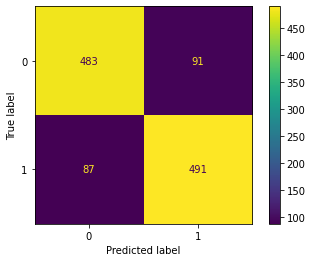

In [34]:
cm = confusion_matrix(y_test, y_pred, labels=LR.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=LR.classes_)
disp.plot()
plt.show()

#### И завершим всё на Linear SVC

In [35]:
L_SVC= LinearSVC()
L_SVC.fit(tfidf_train, y_train)

y_pred=L_SVC.predict(tfidf_test)
score_L_SVC=accuracy_score(y_test, y_pred)
print(f'Точность Linear SVC: {round(score_L_SVC*100,2)}%')

Точность Linear SVC: 85.42%


In [36]:
confusion_matrix(y_test,y_pred)

array([[490,  84],
       [ 84, 494]])

In [37]:
print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85       574
           1       0.85      0.85      0.85       578

    accuracy                           0.85      1152
   macro avg       0.85      0.85      0.85      1152
weighted avg       0.85      0.85      0.85      1152



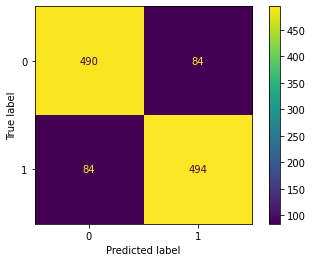

In [38]:
cm = confusion_matrix(y_test, y_pred, labels=L_SVC.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=L_SVC.classes_)
disp.plot()
plt.show()

Результаты классификаторов и их точность:

In [39]:
data_result = pd.DataFrame()

In [40]:
data_result['classifier'] = ['PassiveAggressiveClassifier',
                             'MultinomialNB (Naive Bayes)', 
                             'Logistic Regression', 'Linear SVC']
data_result['results'] = score_pac, score_NB, score_LR, score_L_SVC

In [42]:
data_result.sort_values(by='results')

,classifier,results
0,PassiveAggressiveClassifier,0.827257
2,Logistic Regression,0.845486
3,Linear SVC,0.854167
1,MultinomialNB (Naive Bayes),0.855903


Из таблички видно, что лучшим из 4-х классификаторов оказался `MultinominalNB`, поэтому прогоним через эту модель тестовый датасет и определим фейковый заголовок или нет.

In [43]:
#импортируем тестовый набор
df_new = pd.read_csv("../nlp_test_task_2022/dataset/test.tsv", sep='\t')

In [44]:
#приводим слова в заголовках к начальной форме
df_new['title_normalize'] = df_new['title'].apply(lemmatize)
tfidf_test=tfidf_vectorizer.transform(df_new['title_normalize'])

In [45]:
new_label_test = []
for doc, category in zip(df_new['title'], NB.predict(tfidf_test)):
    print('%r => %s' % (doc, category))
    new_label_test.append(category)

'Роскомнадзор представил реестр сочетаний цветов, нежелательных в России' => 1
'Ночью под Минском на президентской горе Беларашмор (Пик Демократии) внезапно появилось лицо Николая Лукашенко' => 1
'Бывший спичрайтер Юрия Лозы рассказал о трудностях работы с Сергеем Шойгу' => 1
'Сельская церковь, собравшая рекордно низкое количество пожертвований, сгорела от тройного попадания молнии' => 1
'Акции Google рухнули после объявления о перезапуске RuTube' => 0
'Курс доллара вырос до исторического максимума' => 0
'ОПЕК назвала оптимальный уровень цен на нефть' => 0
'Российская авиакомпания откроет рейсы в Тбилиси с Урала' => 0
'Швейцарская горнолыжница расстреляна в доме родителей' => 1
'Учреждена театральная премия имени Гарольда Пинтера' => 0
'Песков опроверг информацию о слиянии Минфина и Минэкономразвития' => 0
'В рамках акции «Елка желаний» министр науки и высшего образования исполнил мечту Алисы Тепляковой и подарил ей красный диплом МГУ' => 1
'Главного злодея в сериале «Этерна» сыграет Р

In [44]:
df_new['is_fake'] = new_label_test

In [45]:
df_new = df_new.drop(['title_normalize'], axis=1)

In [46]:
df_new

,title,is_fake
0,Роскомнадзор представил реестр сочетаний цвето...,1
1,Ночью под Минском на президентской горе Белара...,1
2,Бывший спичрайтер Юрия Лозы рассказал о трудно...,1
3,"Сельская церковь, собравшая рекордно низкое ко...",1
4,Акции Google рухнули после объявления о переза...,0
...,...,...
995,Прокуратура заподозрила Явлинского в авторитар...,1
996,В День Победы стратегические ракетоносцы Ту-16...,1
997,СК возбудил дело против авиакомпании «Победа» ...,1
998,Криптомонетный двор Туркменистана выпустил юби...,1


In [51]:
#сохраняем результат предсказания для теста
df_new.to_csv('predictions.tsv', sep='\t', index=False)

В scikit-learn есть класс Pipeline, который функционирует как составной (конвейерный) классификатор. Это позволяет довольной быстро работать с различными цепочками, например, vectorizer -> transformer -> classifier

In [47]:
pipe=Pipeline([('tfidf', TfidfVectorizer()),
               ('Linear SVC', LinearSVC()),
               ])

In [48]:
pipe.fit(df['title_normalize'],df['is_fake'])

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('Linear SVC', LinearSVC())])

Ради интереса была взят фейковый заголовок с `https://panorama.pub` и реальный заголовок с `https://ura.news`, дабы проверить предсказание пайплайна:

In [49]:
Pred_News1=['В Киргизии перенесли День Победы на 8 мая']
print(pipe.predict(Pred_News1))

[1]


In [50]:
Pred_News2=['В Иерусалиме сошел Благодатный огонь']
print(pipe.predict(Pred_News2))

[0]
